**Imports**

In [ ]:
import glob
import os
import numpy as np
import cv2
import random
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, figure
import math

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence

from skimage.metrics import structural_similarity as ssim

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


**Build Datasets**

In [ ]:
# set the path to overarching project folder within google drive 
project_dir = '/content/gdrive/shared-with-me/FinalProject_BMENE4470_2021/'

# set the path to overarching timelapse folder within google drive 
tmlps_dir = project_dir + 'timelapses/'

# set the paths to the sub-directories containing train, val, & test timelapses
train_dir = tmlps_dir + 'train/'
val_dir = tmlps_dir + 'val/'
test_dir = tmlps_dir + 'test/'

In [ ]:
# definition for getting paths to each individual timelapse folder

def get_tmlps_paths(dir):

  # get list of individual tmlps expts
  unzip_tmlps_paths = glob.glob(dir + "/*(Unzipped Files)")

  # empty array for storing individual tmlps paths
  individ_tmlps_paths = []

  # loop through the individual tmlps folders
  for u in unzip_tmlps_paths:
    # the tmlps frames are actually stored in a sub-folder '*_polarims'
    polarim_fold = glob.glob(u + "/*_polarims")
    individ_tmlps_paths.append(polarim_fold[0])

  return individ_tmlps_paths

In [ ]:
# get paths to individual train, val, & test timelapses
train_tmlps_paths = get_tmlps_paths(train_dir)
val_tmlps_paths = get_tmlps_paths(val_dir)
test_tmlps_paths = get_tmlps_paths(test_dir)

# print number of timelapses
print(str(len(train_tmlps_paths)) + ' train timelapses')
print(str(len(val_tmlps_paths)) + ' val timelapses')
print(str(len(test_tmlps_paths)) + ' test timelapses')

0 train timelapses
0 val timelapses
0 test timelapses


In [ ]:
# definition for determining min number of frames available across all timelapses
def get_tmlps_length(all_tmlps_paths):
    num_frames_list = []
    for p in all_tmlps_paths:
        frames_list = os.listdir(p)
        num_frames = len(frames_list)
        num_frames_list.append(num_frames)
    tmlps_length = min(num_frames_list)   
    return tmlps_length    

In [ ]:
# determining min number of frames available
all_tmlps_paths = train_tmlps_paths + val_tmlps_paths + test_tmlps_paths
tmlps_length = get_tmlps_length(all_tmlps_paths)
print('All timelapses have at least ' + str(tmlps_length) + ' frames')

All timelapses have at least 156 frames


In [ ]:
# Custom data generator

class DataGenerator(Sequence):
  'Generates data for Keras'
  def __init__(self, tmlps_paths, tmlps_length, start_frame=0, time_step=1, frame_height=64, frame_width=64, batch_size=5, shuffle=True):

    'Initilization'
    self.tmlps_paths = tmlps_paths
    self.tmlps_length = tmlps_length
    self.start_frame = start_frame
    self.time_step = time_step
    self.frame_height = frame_height
    self.frame_width = frame_width
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Denotes the number of batches per epoch'
    return int(np.floor(len(self.tmlps_paths) / self.batch_size))

  def __getitem__(self, index):
    'Generates one batch of data (index = index of the batch)'
    # generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # find list of paths
    tmlps_paths_temp = [self.tmlps_paths[k] for k in indexes]

    # generate data
    dataset = self.extract_frames(tmlps_paths_temp)

    # shift the frames
    x, y = self.shift_frames(dataset)
    return x, y

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.tmlps_paths))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def extract_frames(self, tmlps_paths_temp):
    # determine how many timelapses in each batch (should be batch_size)
    num_tmlps = len(tmlps_paths_temp)

    # determine how many frames we'll use from each tmlps
    num_frames = int(np.floor((self.tmlps_length-self.start_frame)/self.time_step)) 

    # set up array for storing timelapse frames
    dataset = np.empty(shape=(num_tmlps, num_frames, self.frame_height, self.frame_width)) 

    # loop through each timelapse & store frames
    for t in range(num_tmlps):
      # get individual tmlps path
      path_t = tmlps_paths_temp[t]
      # get list of image frames in a single timelapse
      frames_list = glob.glob(path_t + "/*.tif")
      # sort the frames in order
      frames_list.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))

      # initialize counter for storing frames:
      count_f = 0

      # loop through the frames & store them
      for f in range(self.start_frame, self.tmlps_length, self.time_step):
        frame_path = frames_list[f]
        # read in frame as grayscale image
        frame = cv2.imread(frame_path,cv2.IMREAD_UNCHANGED)
        # resize frame
        frame = cv2.resize(frame, (self.frame_height, self.frame_width), interpolation = cv2.INTER_NEAREST) 
        # normalize to 0-1 range
        frame = frame/255
        # store frame in dataset array
        dataset[t,count_f,:,:] = frame
        # update counter
        count_f = count_f + 1
        
    # Add a channel dimension since the images are grayscale
    dataset = np.expand_dims(dataset, axis=-1)
    return dataset

  # function for shifting frames
  # where `x` is frames 0 to n - 1, and `y` is frames 1 to n.
  def shift_frames(self, dataset):
    x = dataset[:, 0:dataset.shape[1]-1, :, :]
    y = dataset[:, 1:dataset.shape[1], :, :]
    return x, y


In [ ]:
# Set parameters for data generators
start_frame=tmlps_length-20 #for now, let's just train on the last 20 frames
time_step=1 #for now, let's not skip any of the last 20 frames
frame_height=64
frame_width=64
train_batch_size=3
val_batch_size=1
test_batch_size=1

In [ ]:
# data generators

train_generator = DataGenerator(train_tmlps_paths, tmlps_length, 
                                start_frame=start_frame, time_step=time_step,
                                frame_height=frame_height, frame_width=frame_width, 
                                batch_size=train_batch_size, shuffle=True)

val_generator = DataGenerator(val_tmlps_paths, tmlps_length, 
                              start_frame=start_frame, time_step=time_step,
                              frame_height=frame_height, frame_width=frame_width, 
                              batch_size=val_batch_size, shuffle=True)

test_generator = DataGenerator(test_tmlps_paths, tmlps_length, 
                              start_frame=start_frame, time_step=time_step,
                              frame_height=frame_height, frame_width=frame_width, 
                              batch_size=test_batch_size, shuffle=False)

In [ ]:
# for confirmation, print the size of 1 batch from the val data generator
x_val_0, y_val_0 = val_generator[0]

print('Shape of shifted frame sets from a validation data batch:')
print(x_val_0.shape)
print(y_val_0.shape)


Shape of shifted frame sets from a validation data batch:
(1, 19, 64, 64, 1)
(1, 19, 64, 64, 1)


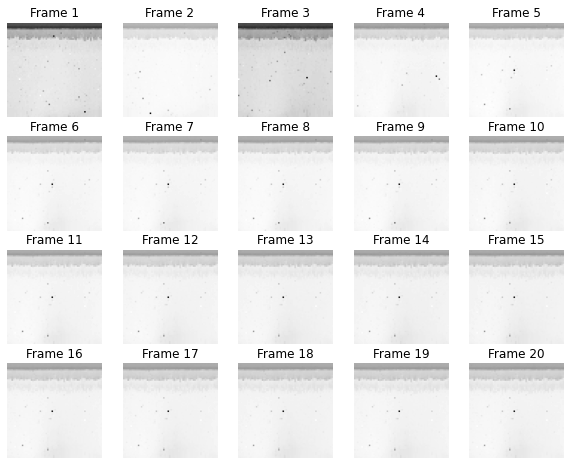

In [ ]:
# let's view the last 20 frames from a val batch 

fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
for idx, ax in enumerate(axes.flat):
  if idx < 19:
    ax.imshow(np.squeeze(x_val_0[0][idx]), cmap="gray")
  else:
    # the last frame is in the shifted y set
    ax.imshow(np.squeeze(y_val_0[0][idx-1]), cmap="gray")

  ax.set_title(f"Frame {idx + 1}")
  ax.axis("off")

plt.show()

Model Construction

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_val_0.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)


In [ ]:
# define hyperparameters
loss = keras.losses.MeanSquaredError()
lr = 1e-4 
optimizer = keras.optimizers.Adam(lr)
metrics = keras.metrics.Accuracy()
epochs = 2 #20

In [ ]:
# let's test the ssim metric

img1 = np.squeeze(x_val_0[0][0])
img2 = np.squeeze(x_val_0[0][1])

# show that it is 1 for the same image
ssim_same = ssim(img1, img1)
print(ssim_same)

# show that it is slightly less than 1 for 2 adjacent images in a timelapse
ssim_diff = ssim(img1, img2)
print(ssim_diff)

1.0
0.9519389005312687


In [ ]:
# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Model Training

In [ ]:
# define the name of the model for saving it
model_type = 'ConvLSTM'
my_version = 'a'
date = '12-01-21'
my_initials = 'MS'

model_name = '_'.join([model_type,my_version,date,my_initials])
model_path = project_dir + 'saved_models/' + model_name + '_{epoch:02d}.h5' 


In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

save_model = keras.callbacks.ModelCheckpoint(model_path, monitor="val_loss",
                                             verbose=1, save_best_only = True,
                                             mode='min')

In [ ]:
history = model.fit_generator(generator=train_generator,
                    validation_data=val_generator,
                    epochs=epochs,
                    callbacks=[early_stopping, reduce_lr, save_model],
                    use_multiprocessing=True,
                    workers=6,
                    verbose=1,)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/2
12/12 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 3.5693e-07 
Epoch 00001: val_loss improved from inf to 0.07206, saving model to /content/gdrive/MyDrive/Fall 2021 Courses/Deep Learning Biosignal Processing/FinalProject_BMENE4470_2021/saved_models/ConvLSTM_quickrun_12-01-21_MS_01.h5
12/12 [==============================] - 432s 33s/step - loss: 0.0138 - accuracy: 3.5693e-07 - val_loss: 0.0721 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/2
12/12 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 7.1386e-07 
Epoch 00002: val_loss improved from 0.07206 to 0.06503, saving model to /content/gdrive/MyDrive/Fall 2021 Courses/Deep Learning Biosignal Processing/FinalProject_BMENE4470_2021/saved_models/ConvLSTM_quickrun_12-01-21_MS_02.h5
12/12 [==============================] - 403s 33s/step - loss: 0.0032 - accuracy: 7.1386e-07 - val_loss: 0.0650 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04


In [ ]:
# diplay history
history.history

In [ ]:
# save history dictionary
import pickle

history_path = project_dir + 'saved_models/' + model_name + '_hist.pckl'

file_pi = open(history_path, 'wb')
pickle.dump(history.history, file_pi)
file_pi.close()

# to retrieve it, you would do: 
# file_pi = open(history_path, 'rb')
# history = pickle.load(file_pi)
# file_pi.close()

In [ ]:
# plot learning curves

**Frame Prediction Visualizations**

In [ ]:
# function for visualizing frame predictions

def vis_preds(x, y, batch_size):

  # extract random sample from a batch 
  sample_num = np.random.choice(range(batch_size))

  # Pick the first ten frames from the sample
  frames = x[sample_num][:10, ...]

  # Pick the last ten frames from the sample
  original_frames = y[sample_num][9:, ...]

  # Predict a new set of 10 frames.
  for _ in range(10):
      # Extract the model's prediction and post-process it.
      new_prediction = model.predict(np.expand_dims(frames, axis=0))
      new_prediction = np.squeeze(new_prediction, axis=0)
      predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

      # Extend the set of prediction frames.
      frames = np.concatenate((frames, predicted_frame), axis=0)
  
  # Construct a figure for the original and new frames.
  fig, axes = plt.subplots(2, 10, figsize=(20, 4))

  # Plot the original frames.
  for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

  # Plot the new frames.
  new_frames = frames[10:, ...]
  for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

  # Display the figure.
  plt.show()


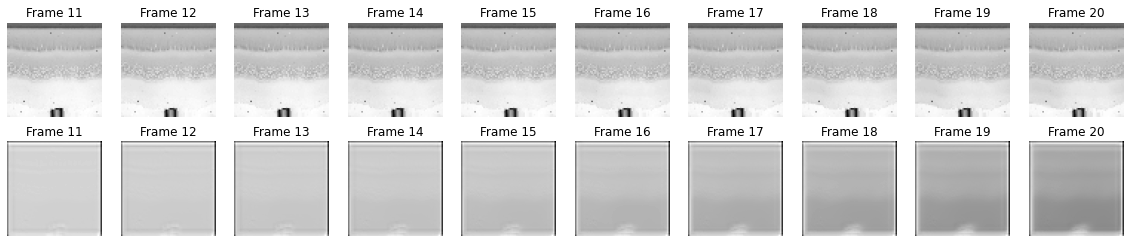

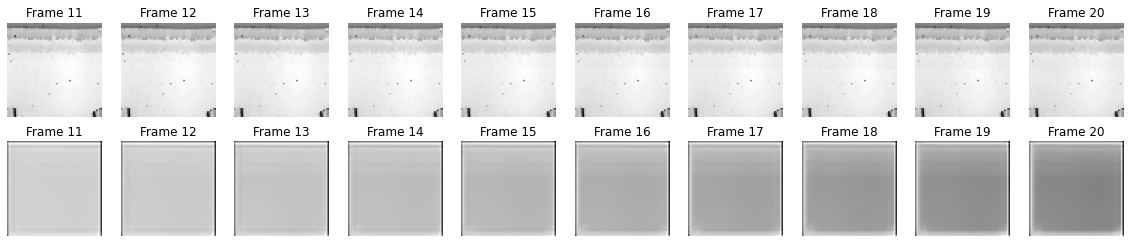

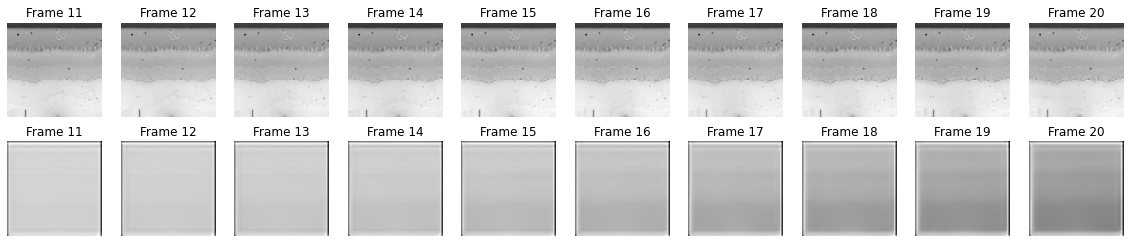

In [ ]:
# visualize some predictions on train samples

num_train_samples = len(train_tmlps_paths)
num_train_batches = int(num_train_samples/train_batch_size)

batch_group = np.random.choice(range(num_train_batches), size=3)

for b in batch_group:
  x_train, y_train = train_generator[b]
  vis_preds(x_train, y_train, train_batch_size)

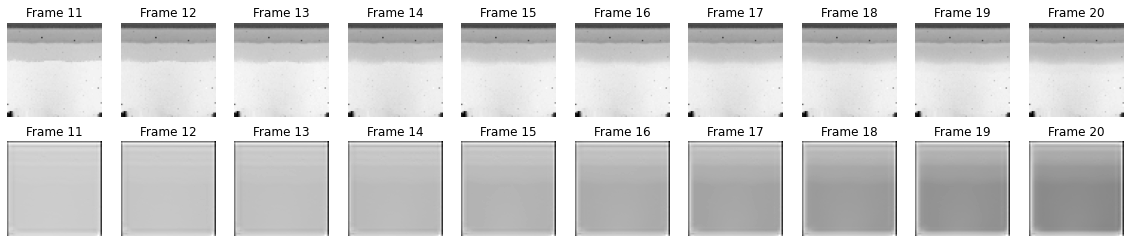

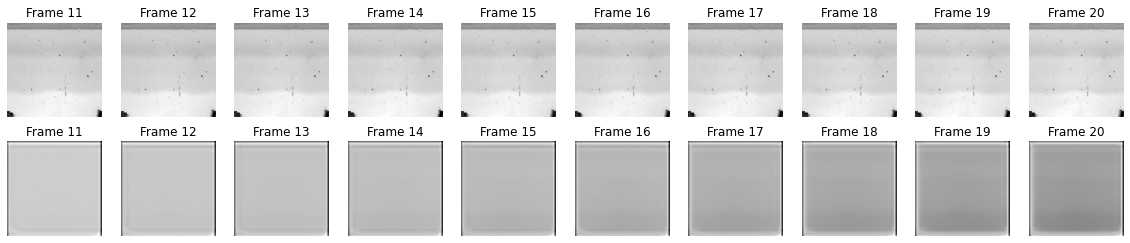

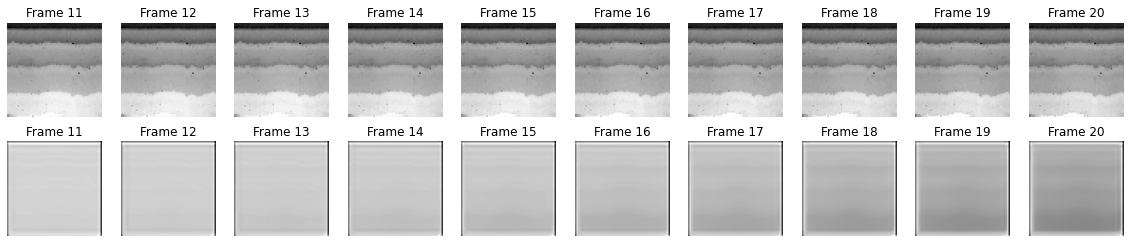

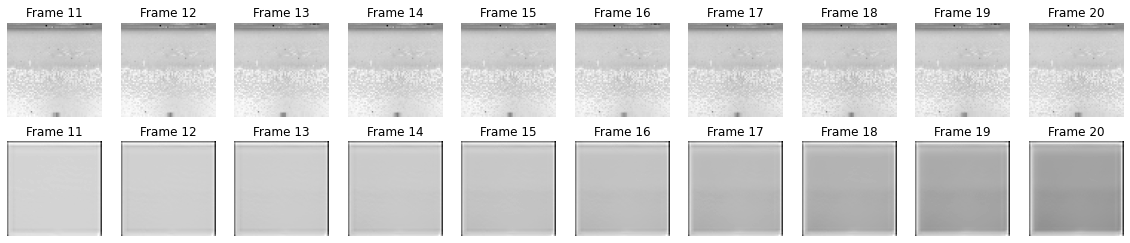

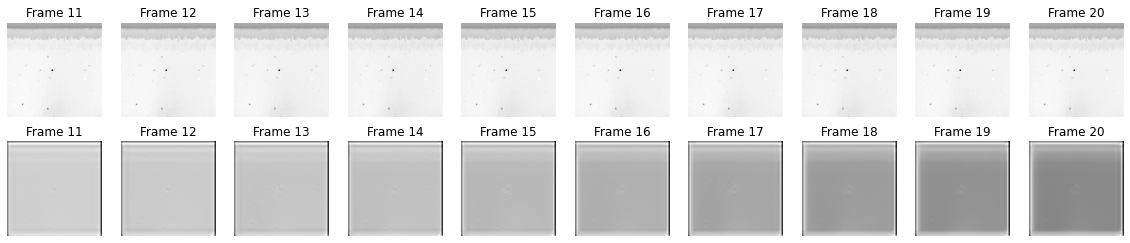

In [ ]:
# visualize predictions on all val samples

num_val_samples = len(val_tmlps_paths)
num_val_batches = int(num_val_samples/val_batch_size)

for v in range(num_val_batches):
  x_val, y_val = val_generator[v]
  vis_preds(x_val, y_val, val_batch_size)

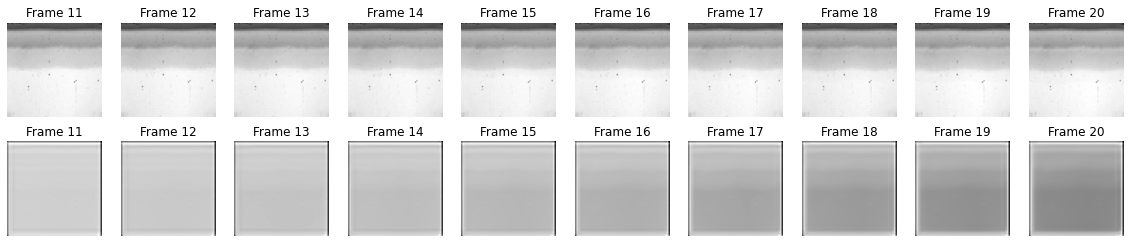

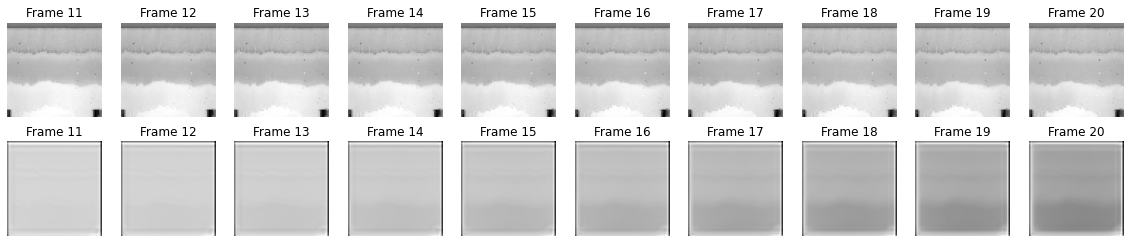

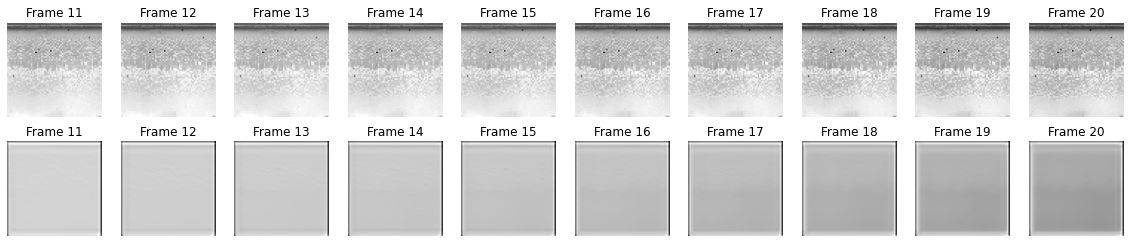

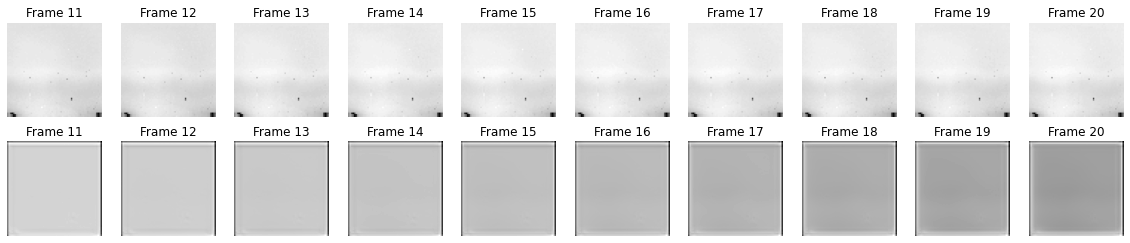

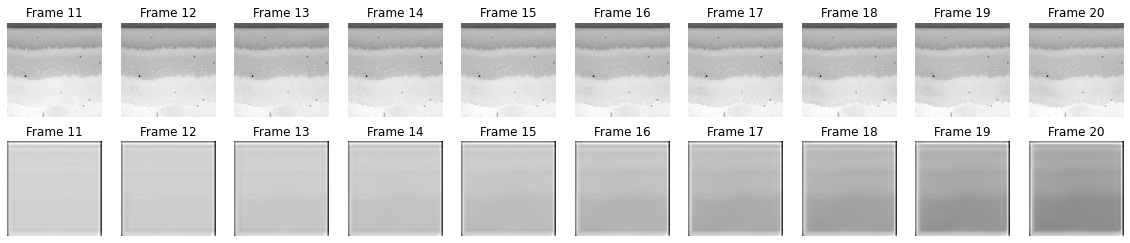

In [ ]:
# visualize predictions on all test samples

num_test_samples = len(test_tmlps_paths)
num_test_batches = int(num_test_samples/test_batch_size)

for t in range(num_test_batches):
  x_test, y_test = test_generator[t]
  vis_preds(x_test, y_test, test_batch_size)
